In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as t
from scipy.stats import mode

In [20]:
df=pd.read_csv('../data/uciData.csv')
train=df.sample(frac=0.7,random_state=200) #random state is a seed value
test=df.drop(train.index)
predictors = train.columns[:-1]
train.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


## Inference

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [all_coeff, address_coeff, make_coeff]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:12<00:00, 575.94draws/s]


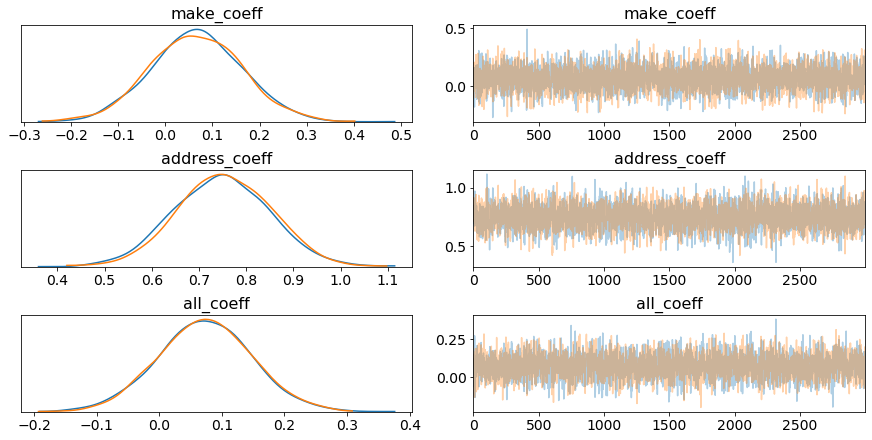

In [21]:
with pm.Model() as model: 
    
    # Data
    make_shared = pm.Data('make', train['word_freq_make'])
    address_shared = pm.Data('address', train['word_freq_address'])
    all_shared = pm.Data('all', train['word_freq_all'])
    
    # Define priors
    #intercept = pm.Normal('Intercept', 0, sd=20)
    make_coeff = pm.Normal('make_coeff', 0, sd=20)
    address_coeff = pm.Normal('address_coeff', 0, sd=20)
    all_coeff = pm.Normal('all_coeff', 0, sd=20)

    
    # Define likelihood
    logistic = pm.math.sigmoid(make_coeff * make_shared + address_coeff * address_shared
                              + all_coeff * all_shared)
    likelihood = pm.Bernoulli( 'y', 
                              p = logistic,
                              observed = train['spam'] ) 

    # Inference!
    trace = pm.sample(3000)
    

pm.traceplot(trace)
plt.show()


## Prediction

In [16]:
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({'make': test['word_freq_make'],
                 'address': test['word_freq_address']})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

100%|██████████| 500/500 [00:01<00:00, 431.01it/s]


In [17]:
post_pred['y'].shape

(500, 1380)

In [19]:
post_pred['y']

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 1, 0]])